In [22]:
import pandas as pd
import torch
import os
import re

import pyprobound
import pyprobound.plotting
import pyproboundextensions.pbm as pbe
import pyprobound.fitting
import torch.nn.functional as F
import matplotlib.pyplot as plt

import json
import numpy as np
import scipy

In [11]:
f = open('test/motifcentral_fit_15412.json')
model = json.load(f)

tensor([[-4.3810,  0.0000, -3.9521, -1.7619, -1.1445, -1.7790],
        [ 0.0000, -4.6313,  0.0000, -3.1270, -0.0990, -1.5851],
        [-4.4718, -2.4981, -3.7631,  0.0000, -1.7218,  0.0000],
        [-3.3233, -2.6203, -2.5465, -2.3434,  0.0000, -1.0842]],
       grad_fn=<SelectBackward0>)


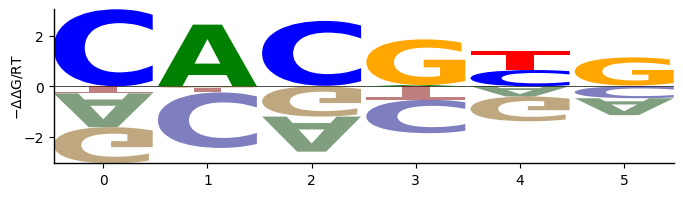

In [12]:
alphabet = pyprobound.alphabets.DNA()
kernel_size = int(model["modelSettings"]["bindingModes"][-1]["size"])
pairwise_distance = min(
    kernel_size - 1,
    int(
        model["modelSettings"]["bindingModes"][-1]["dinucleotideDistance"]
    ),
)
psam = pyprobound.layers.PSAM(
    kernel_size=kernel_size,
    pairwise_distance=pairwise_distance,
    alphabet=alphabet,
    normalize=False,
    train_betas=False,
)
mono = model["coefficients"]["bindingModes"][-1]["mononucleotide"]
di = model["coefficients"]["bindingModes"][-1]["dinucleotide"]
alphalen = len(alphabet.alphabet)
for key, param in psam.betas.items():
    elements = [int(i) for i in key.split("-")]
    elements = [i - 1 for i in elements[:-1]] + elements[-1:]
    if len(elements) == 2:
        torch.nn.init.constant_(
            param, mono[elements[0] * alphalen + elements[1]]
        )
    else:
        torch.nn.init.constant_(
            param,
            di[elements[1] - elements[0] - 1][
                elements[0] * (alphalen**2) + elements[2]
            ],
        )
print(psam.get_filter(0)[0])
pyprobound.plotting.logo(psam)

In [41]:
id = 'M00009_2.00'
alphabet = pyprobound.alphabets.DNA()
dataframe_PBM = pd.read_csv(
    f"CountTables/{id}_CT.tsv", header=0, index_col=0, sep="\t"
)  
count_table = pyprobound.CountTable(
    dataframe_PBM,
    alphabet,
    left_flank="",
    right_flank="",
    left_flank_length=0,
    right_flank_length=0,
)
nonspecific = pyprobound.layers.NonSpecific(alphabet=alphabet, name="NS")
psams = [
    psam
    #pyprobound.layers.PSAM(
    #    kernel_size=8,
    #    alphabet=alphabet,
    #    increment_flank=True,
    #    shift_footprint_heuristic=True,
    #    increment_footprint=True,
    #    increment_flank_with_footprint=True,
    #),
]
conv0d = pyprobound.layers.Conv0d.from_nonspecific(nonspecific, count_table)
conv1ds = [
    pyprobound.layers.Conv1d.from_psam(psam, count_table) for psam in psams
]

modes = [pyprobound.Mode([conv0d])] + [
    pyprobound.Mode([conv1d]) for conv1d in conv1ds
]
round_0 = pyprobound.rounds.InitialRound()
round_1 = pyprobound.rounds.BoundUnsaturatedRound.from_binding(modes, round_0, activity_heuristic = 0.8, train_depth=False)

model = pbe.MultiExperimentLogMSELoss([round_1], pseudocount=20,)
optimizer = pyprobound.Optimizer(
    model,
    [count_table],
    greedy_threshold=2e-4,
    device="cpu",
    checkpoint=f"test.pt",
    output=f"test.txt",
)

/mnt/e/desktop/test.github.io/PyProBound/venv/lib/python3.10/site-packages/pyprobound/optimizer.py:145: UserWarning: Output file test.txt is not empty
  warnings.warn(f"Output file {output} is not empty")
/mnt/e/desktop/test.github.io/PyProBound/venv/lib/python3.10/site-packages/pyprobound/optimizer.py:147: UserWarning: Checkpoint file test.pt is not empty
  warnings.warn(f"Checkpoint file {checkpoint} is not empty")


In [42]:
round_1.aggregate.contributions[-1].binding.layers[-1].layer_spec.get_filter(0)[0]

tensor([[-4.3810,  0.0000, -3.9521, -1.7619, -1.1445, -1.7790],
        [ 0.0000, -4.6313,  0.0000, -3.1270, -0.0990, -1.5851],
        [-4.4718, -2.4981, -3.7631,  0.0000, -1.7218,  0.0000],
        [-3.3233, -2.6203, -2.5465, -2.3434,  0.0000, -1.0842]])

In [43]:
optimizer.train_sequential()

tensor(1.8850)

tensor(1.8848) tensor(0.0002) tensor(1.8850)
M00009_2.00


/mnt/e/desktop/test.github.io/PyProBound/venv/lib/python3.10/site-packages/pyprobound/optimizer.py:147: UserWarning: Checkpoint file pyPBtemp/M00009_2.00_check.pt is not empty
  warnings.warn(f"Checkpoint file {checkpoint} is not empty")


<Figure size 640x480 with 0 Axes>

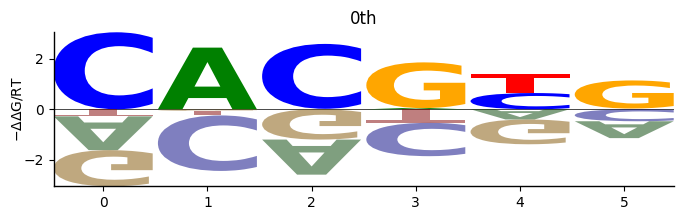

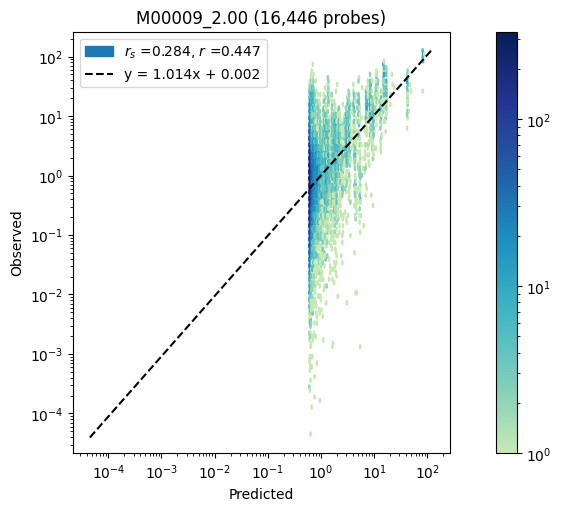

In [44]:
optimizer.reload()
with torch.inference_mode():
    loss, reg = model([count_table])
    print(loss, reg, loss + reg)

print(f"{id}")
plt.figure()
pyprobound.plotting.logo(psams[0])
prediction = lambda log_aggregate: F.logsigmoid(log_aggregate)
fit = pyprobound.fitting.LogFit(
    round_1,
    count_table,
    prediction,
    update_construct=False,
    train_offset=True,
    device="cpu",
    name=f"{id}",
    checkpoint=f"pyPBtemp/{id}_check.pt",
)
fit.fit()
fit.plot(kernel=1)
plt.show()


In [35]:
optimizer.train_sequential()
obs, log_pred = pyprobound.score(round_1, count_table)
log_obs = obs.squeeze().log()

ValueError: too many values to unpack (expected 2)

In [45]:
pcc, pval = scipy.stats.pearsonr(log_obs, log_pred)

In [46]:
print(pcc)

0.44690847955327845
